# Imports

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# stdlib
import os
import shutil
import sqlite3

# 3rd party
from IPython.display import display
import ipyparallel as ipp
import ipyvolume as ipv
import ipywidgets as ipw
import numpy as np
from scipy.optimize import minimize, curve_fit
from sklearn import linear_model
from sklearn.metrics import r2_score
import sympy as sp
import matplotlib.pyplot as plt

# local
import convergence as conv
import kelp_analyze
import kelp_compute
import mms
import discrete_plot
import run_utils as ru
#from fortran_wrappers.light_utils_wrap import light_utils_wrap as lu

In [108]:
from scipy.spatial import ConvexHull

In [14]:
def is_upper_bound(x_arr, y_arr, m, b):
    return np.all(y_arr<=m*x_arr+b)

def get_line(x1, x2, y1, y2):
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m*x1
    return m, b

def get_lines(x_arr, y_arr):
    """
    Return slope and intercept of all lines between adjacent points
    (and between last and first)
    """
    n = len(x_arr)
    lines = []
    for i in range(n):
        m, b = get_line(
            x_arr[i], 
            x_arr[(i+1)%n],
            y_arr[i], 
            y_arr[(i+1)%n],
        )
        lines.append([m, b])
        
    return lines

def exp_upper_bound(x_arr, y_arr):
    lx = np.log(x_arr)
    ly = np.log(y_arr)
    
    points = np.vstack([lx, ly]).T
    hull = ConvexHull(points)
    
    xv = lx[hull.vertices]
    yv = ly[hull.vertices]
    
    best_err = np.inf
    best_line = (0, 0)
    for i, (m, b) in enumerate(get_lines(xv, yv)):
        if is_upper_bound(xv, yv, m, b):
            err = np.sum(m*lx + b - ly)
            if err < best_err:
                best_line = (m, b)
                best_err = err
            
    return best_line

def robust_lin_regression(x_arr, y_arr, regressor=None):
    if regressor:
        reg = getattr(linear_model, regressor)()
    else:
        reg = linear_model.HuberRegressor()
    X = x_arr.reshape(-1, 1)
    y = y_arr
    reg.fit(X, y)
    vals = reg.predict([[0], [1]])
    b = vals[0]
    m = vals[1] - b
    
    return m, b
    
def robust_exp_regression(x_arr, y_arr, regressor=None):
    if regressor:
        reg = getattr(linear_model, regressor)
    else:
        reg = linear_model.HuberRegressor()
    reg.fit(np.log(x_arr).reshape(-1,1), np.log(y_arr))
    vals = reg.predict([[0], [1]])
    b = vals[0]
    m = vals[1] - b
    
    return m, b
    

In [226]:
def get_sm_axes(scalar_metrics, figsize=(12, 6)):
    fig = plt.figure(figsize=figsize)
    sm_ax_list = []
    nsm = len(scalar_metrics)
    for s, (sm, sm_name) in enumerate(scalar_metrics):
        ax = plt.subplot2grid(
            (2*nsm, 2), 
            (2*s, 0), 
            2, 1, 
            fig=fig
        )
        ax.set_xlabel('$ds^2$')
        ax.set_ylabel(sm_name)
        sm_ax_list.append(ax)
    abs_err_ax = plt.subplot2grid((2*nsm, 2), (0, 1), nsm, 1, fig=fig)
    abs_err_ax.set_xlabel('$ds$')
    abs_err_ax.set_ylabel('abs. err.')
    abs_err_ax.set_xscale('log')
    abs_err_ax.set_yscale('log')
    rel_err_ax = plt.subplot2grid((2*nsm, 2), (nsm, 1), nsm, 1, fig=fig)
    rel_err_ax.set_xlabel('$ds$')
    rel_err_ax.set_ylabel('rel. err.')
    rel_err_ax.set_xscale('log')
    rel_err_ax.set_yscale('log')
    plt.tight_layout()
    
    return sm_ax_list, abs_err_ax, rel_err_ax

In [98]:
def get_re_errs(ds_arr, sm_arr):
    m_re, b_re = robust_lin_regression(ds_arr**2, sm_arr, 'LinearRegression')
    abs_err_arr = np.abs(b_re-sm_arr)
    rel_err_arr = abs_err_arr / b_re
    r2 = r2_score(sm_arr, m_re*ds_arr**2+b_re)
    return abs_err_arr, rel_err_arr, r2

In [402]:
def re_conv_plots(conn, study_name, b, fd_flag, num_scatters, re_ds_max=None, err_ds_max=None, ns_list=None, b_list=None, num_scatters_list=None, sm_logx=False):
    #norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
    #norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
    norm = lambda x: np.mean(np.abs(x))

    ns_list_db, b_list_db, num_scatters_list_db = kelp_analyze.get_unique_vals(
        conn, 
        study_name, 
        ['ns', 'b', 'num_scatters']
    )
    if not ns_list:
        ns_list = ns_list_db
    if not b_list:
        b_list = b_list_db
    if not num_scatters_list:
        num_scatters_list = num_scatters_list_db
    
    ns_arr = np.array(ns_list)
    
    if fd_flag:
        num_scatters = 0

    depths = [1, 3, 8]
    scalar_metrics = [
        ('flux', r'$\Phi$'),
        *[
            ('pi_{}'.format(d), 'PI (z={})'.format(d))
            for d in depths
        ]
    ]
    
    sm_ax_list, abs_err_ax, rel_err_ax = get_sm_axes(scalar_metrics)
    out = ipw.Output(layout=ipw.Layout(height='120px', overflow_y='scroll'))

    scalar_metric_array = np.zeros([
        len(ns_arr),
        len(scalar_metrics)
    ])

    for k, ns in enumerate(ns_arr):
        results_list = kelp_analyze.query_results(
            conn, study_name,
            ns=ns,
            fd_flag=fd_flag,
            num_scatters=num_scatters,
            b=b
        )
        scalar_metric_array[k,:] = [
           results_list[0][metric][:]
            for (metric, _) in scalar_metrics
        ]

    # For richardson extrapolation
    if not re_ds_max:
        re_ds_max = 5e-2
    # For fitting errors
    if not err_ds_max:
        err_ds_max = 5e-2

    # TODO: Fix ds
    ds_arr = 1/ns_arr
    inds1 = ds_arr<=re_ds_max
    inds2 = ds_arr<=err_ds_max

    for j, (metric, metric_label) in enumerate(scalar_metrics):
        # Richardson extrapolation
        m_sm, b_sm = robust_lin_regression(ds_arr[inds1]**2, scalar_metric_array[inds1,j], 'LinearRegression')
        best_err = np.abs(b_sm-scalar_metric_array[-1, j])
        best_rel = best_err / b_sm
        r2_sm = r2_score(scalar_metric_array[inds1,j], m_sm*ds_arr[inds1]**2+b_sm)

        # Calculate & fit estimated errors
        abs_err_arr = np.abs(scalar_metric_array[:,j] - b_sm)
        m_abs, b_abs = robust_exp_regression(ds_arr[inds2], abs_err_arr[inds2])
        r2_abs = r2_score(np.log(abs_err_arr[inds2]), m_abs*np.log(ds_arr[inds2])+b_abs)
        rel_err_arr = np.abs(abs_err_arr/b_sm)
        m_rel, b_rel = robust_exp_regression(ds_arr[inds2], rel_err_arr[inds2])
        r2_rel = r2_score(np.log(rel_err_arr[inds2]), m_rel*np.log(ds_arr[inds2])+b_rel)
        
        with out:
            print()
            print(metric)
            print("b_sm={:.2f}".format(b_sm))
            print("best err = {:.2e}".format(best_err))
            print("best rel = {:.2e}".format(best_rel))
            print("r2_sm = {:.2f}".format(r2_sm))
            print("m_err = {:.2f}".format(m_abs))
            print("r2_err = {:.2f}".format(r2_abs))

        # Plot
        sm_ax_list[j].axvline(re_ds_max**2, color='0.5', linestyle='--')
        sm_ax_list[j].errorbar(ds_arr**2, scalar_metric_array[:,j], 1.25*abs_err_arr, None, 'C{}o-'.format(j), capsize=3)
        sm_ax_list[j].plot(ds_arr**2, m_sm*ds_arr**2+b_sm, 'k--'.format(j))
        sm_ax_list[j].axhline(b_sm, color='0.25', linestyle='-.')

        # Plot errors
        #m_err, b_err = exp_upper_bound(ds_arr[inds2], abs_err_arr[inds2])
        abs_err_ax.plot(ds_arr, abs_err_arr, 'C{}o-'.format(j), label='m={:.2f}'.format(m_abs))
        abs_err_ax.plot(ds_arr, np.exp(b_abs)*ds_arr**m_abs, 'C{}--'.format(j))

        # Plot errors
        #m_rel, b_err = exp_upper_bound(ds_arr[inds2], rel_err_arr[inds2])
        rel_err_ax.plot(ds_arr, rel_err_arr, 'C{}o-'.format(j), label='m={:.2f}'.format(m_rel))
        rel_err_ax.plot(ds_arr, np.exp(b_rel)*ds_arr**m_rel, 'C{}--'.format(j))
        
    if sm_logx:
        for ax in sm_ax_list:
            ax.set_xscale('log')

    abs_err_ax.axvline(err_ds_max, color='0.5', linestyle='--')
    abs_err_ax.legend()
    rel_err_ax.axvline(err_ds_max, color='0.5', linestyle='--')
    rel_err_ax.legend()
    plt.show()
    display(out)

In [403]:
def sm_dashboard(conn, study_name, ns_list=None, b_list=None, num_scatters_list=None):
    ns_list_db, b_list_db, num_scatters_list_db = kelp_analyze.get_unique_vals(
        conn, 
        study_name, 
        ['ns', 'b', 'num_scatters']
    )
    if not ns_list:
        ns_list = ns_list_db
    if not b_list:
        b_list = b_list_db
    if not num_scatters_list:
        num_scatters_list = num_scatters_list_db
    
    b_slider = ipw.SelectionSlider(
        options=list(zip(['{:.2f}'.format(b) for b in b_list], b_list)), 
        description='b',
        continuous_update=False
    )
    num_scatters_slider = ipw.SelectionSlider(
        options=num_scatters_list, 
        description='n',
        continuous_update=False
    )
    fd_checkbox = ipw.Checkbox(
        description='fd_flag'
    )
    sm_logx_checkbox = ipw.Checkbox(
        description='sm_logx'
    )
    int_out = ipw.interactive_output(
        re_conv_plots,
        dict(
            conn=ipw.fixed(conn), 
            study_name=ipw.fixed(study_name),
            ns_list=ipw.fixed(ns_list),
            b_list=ipw.fixed(b_list),
            num_scatters_list=ipw.fixed(num_scatters_list),
            b=b_slider,
            num_scatters=num_scatters_slider,
            fd_flag=fd_checkbox,
            sm_logx=sm_logx_checkbox
        )
    )
    return ipw.VBox([
        ipw.HBox([
            b_slider,
            num_scatters_slider,
            fd_checkbox,
            sm_logx_checkbox
        ]),
        int_out
    ])

## IPyParallel Setup

In [ ]:
#remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()
dv = ipc.direct_view()
print(ipc.ids)

In [ ]:
ipc.queue_status()

# Calculations

## 1D

### Compute

In [ ]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

nz_list = np.logspace(1, 2, 50, base=10).astype(int)
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 0
fd_flag = False
num_threads = 32

a_water = 0.01
b = 0
kelp_dist = 'top-heavy'

study_name = 'verify_kelp_th_bad_abspt_1d_noscat_nz_{}'.format(max(nz_list))
study_dir = os.path.join(base_dir, study_name)

ntheta = na
nphi = na

# TODO: Don't actually delete results

combine_thread, gs_fut = kelp_compute.verify_kelp_1d_compute_scalar_metrics(
    study_name, 
    a_water, b, nz_list, 
    kelp_dist, num_scatters, 
    fd_flag, lis_opts=None, num_threads=num_threads,
    base_dir=base_dir
)

### Plot

In [361]:
study_name = 'verify_kelp_th_bad_abspt_1d_noscat_nz_100'
study_dir = os.path.join(base_dir, study_name)

In [362]:
print(study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

verify_kelp_th_bad_abspt_1d_noscat_nz_100


b=0.48
best err = 2.68e-02
best rel = 5.64e-02
m_err(abs) = 1.56
m_err(rel) = 1.56
b=0.00
best err = 4.57e-06
best rel = 1.74e-02
m_err(abs) = 1.85
m_err(rel) = 1.85
b=0.00
best err = 4.16e-12
best rel = 1.02e-02
m_err(abs) = 2.11
m_err(rel) = 2.11


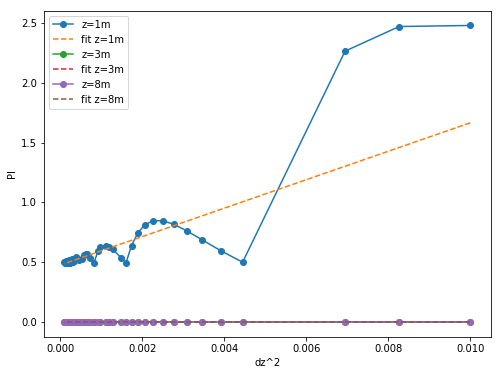

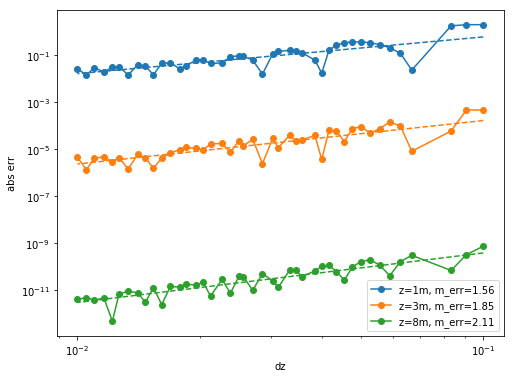

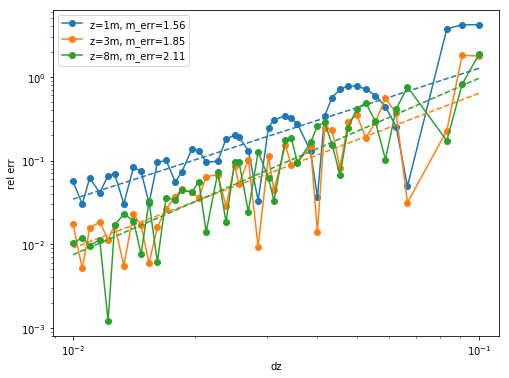

In [363]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

nz_list, = kelp_analyze.get_unique_vals(conn, study_name, ['nz'])

nz_arr = np.array(nz_list)

fig1 = plt.figure(1, figsize=[8,6])
fig2 = plt.figure(2, figsize=[8,6])
fig3 = plt.figure(3, figsize=[8,6])

pi_arr = np.zeros([len(nz_arr), 3])
flux_arr = np.zeros(len(nz_arr))


# For richardson extrapolation
dz_max1 = 5e-2

# For fitting errors
dz_max2 = 1e-1

for k, nz in enumerate(nz_arr):
    results_list = kelp_analyze.query_results(
        conn, study_name,
        nz=nz
    )

    flux = results_list[0]['flux'][:]
    pi_1 = results_list[0]['pi_1'][:]
    pi_3 = results_list[0]['pi_3'][:]
    pi_8 = results_list[0]['pi_8'][:]
    
    flux_arr[k] = flux
    pi_arr[k, :] = [pi_1, pi_3, pi_8]
    
dz_arr = 1/nz_arr

depths = [1, 3, 8]
inds1 = dz_arr<dz_max1
inds2 = dz_arr<dz_max2
for j, d in enumerate(depths):
    # Estimate true soln.
    plt.figure(1)
    #plt.plot(dz_arr, pi_arr[:,0], 'o-', label='z=1m')
    #plt.plot(dz_arr, pi_arr[:,1], 'o-', label='z=3m')
    plt.plot(dz_arr**2, pi_arr[:,j], 'o-', label='z={:d}m'.format(d))
    popt, pcov = curve_fit(lambda x, m, b: m*x+b, dz_arr[inds1]**2, pi_arr[inds1,j], p0=[0, 0])
    m, b = popt
    plt.plot(dz_arr**2, m*dz_arr**2+b, '--', label='fit z={:d}m'.format(d))
    print("b={:.2f}".format(b))
    best_err = np.abs(b-pi_arr[-1, j])
    best_rel = best_err / b
    print("best err = {:.2e}".format(best_err))
    print("best rel = {:.2e}".format(best_rel))
    
    abs_err_arr = np.abs(pi_arr[:,j] - b)
    rel_err_arr = np.abs(abs_err_arr/b)
    
    # Plot errors
    plt.figure(2)
    popt, pcov = curve_fit(lambda x, m, b: m*x+b, np.log(dz_arr[inds2]), np.log(abs_err_arr[inds2]), p0=[2, 0])
    m_err, b_err = popt
    plt.plot(dz_arr, abs_err_arr, 'C{}o-'.format(j), label='z={:d}m, m_err={:.2f}'.format(d, m_err))
    plt.plot(dz_arr, np.exp(b_err)*dz_arr**m_err, 'C{}--'.format(j))
    print("m_err(abs) = {:.2f}".format(m_err))
    
    # Plot errors
    plt.figure(3)
    popt, pcov = curve_fit(lambda x, m, b: m*x+b, np.log(dz_arr[inds2]), np.log(rel_err_arr[inds2]), p0=[2, 0])
    m_err, b_err = popt
    plt.plot(dz_arr, rel_err_arr, 'C{}o-'.format(j), label='z={:d}m, m_err={:.2f}'.format(d, m_err))
    plt.plot(dz_arr, np.exp(b_err)*dz_arr**m_err, 'C{}--'.format(j))
    print("m_err(rel) = {:.2f}".format(m_err))
    
plt.figure(1)
plt.title('')
plt.xlabel('dz^2')
plt.ylabel('PI')
plt.legend()

plt.figure(2)
plt.title('')
plt.legend()
plt.xlabel('dz')
plt.ylabel('abs err')
plt.xscale('log')
plt.yscale('log')

plt.figure(3)
plt.title('')
plt.legend()
plt.xlabel('dz')
plt.ylabel('rel err')
plt.xscale('log')
plt.yscale('log')

## 3D

### Compute

In [ ]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

na = 8
ns_list = np.logspace(1, 2, 11, base=10).astype(int)

study_name = 'verify_kelp_th_bad_abspt_ss_a05_b03_scat1_test_{}x{}_few'.format(max(ns_list), na)
study_dir = os.path.join(base_dir, study_name)

ntheta = na
nphi = na

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 1
fd_flag = False

a_water = 0.5
b = 0
kelp_dist = 'top-heavy'

combine_thread, gs_fut = kelp_compute.verify_kelp_single_space_compute_scalar_metrics(
    study_name, 
    a_water, b, ns_list[::-1], na, 
    kelp_dist, num_scatters, 
    fd_flag, lis_opts=None, num_threads=None,
    base_dir=base_dir
)

### Plot

In [364]:
study_name = 'verify_kelp_th_bad_abspt_ss_a05_b03_scat1_test_100x8_few'
study_dir = os.path.join(base_dir, study_name)

In [365]:
print(study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

verify_kelp_th_bad_abspt_ss_a05_b03_scat1_test_100x8_few


In [366]:
sm_dashboard(conn, study_name)

# Full Asym VoC

## Compute

In [ ]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

ns_list = np.logspace(1, 2, 11, base=10).astype(int)
b_list = np.logspace(-0.5, 0, 10)
num_scatters_list = [0, 1, 2, 3]

na = 8
a_water = 0.5
kelp_dist = 'top-heavy'
do_fd = True

study_name = 'verify_kelp_bad_abspt_asym_b_scat_ss_sm_th_a05_{}x{}'.format(max(ns_list), na)
study_dir = os.path.join(base_dir, study_name)

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.verify_kelp_asym_b_scat_ss_compute_scalar_metrics(
    study_name,
    ns_list, b_list, num_scatters_list,
    na, a_water, kelp_dist, do_fd, 
    lis_opts=None, num_threads=None, 
    base_dir=base_dir
)

## Plot

In [385]:
study_name = 'verify_kelp_bad_abspt_asym_b_scat_ss_sm_th_a05_100x8'
study_dir = os.path.join(base_dir, study_name)

In [386]:
print(study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

verify_kelp_bad_abspt_asym_b_scat_ss_sm_th_a05_100x8


In [426]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

ns_list, b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['ns', 'b', 'num_scatters'])
ns_arr = np.array(ns_list)[:-1]

depths = [1, 3, 8]
scalar_metrics = [
    ('flux', r'$\Phi$'),
    *[
        ('pi_{}'.format(d), 'PI (z={})'.format(d))
        for d in depths
    ]
]

# Just use flux for now
sm = scalar_metrics[0]

fd_sm_arr = np.zeros(len(ns_arr))
asym_sm_arr = np.zeros(len(ns_arr))

# For richardson extrapolation
ds_max1 = 5e-2
# For fitting errors
ds_max2 = 5e-2

# TODO: Fix ds
ds_arr = 1/ns_arr
inds1 = ds_arr<=ds_max1
inds2 = ds_arr<=ds_max2

tot_err_arr = np.zeros([
    len(b_list),
    len(num_scatters_list)
])

asym_r2_arr = np.zeros([
    len(b_list),
    len(num_scatters_list)
])

fd_r2_arr = np.zeros([
    len(b_list),
])

for j, b in enumerate(b_list):
    for k, ns in enumerate(ns_arr):
        fd_results_list = kelp_analyze.query_results(
            conn, study_name,
            ns=ns,
            fd_flag=True,
            b=b
        )
        fd_sm_arr[k] = fd_results_list[0][sm[0]][:]
        
    # FD Richardson extrapolation
    fd_abs_err_arr, fd_rel_err_arr, fd_r2 = get_re_errs(ds_arr[inds1], fd_sm_arr[inds1])
    best_fd_sm_val = fd_sm_arr[-1]
    best_fd_sm_err = fd_abs_err_arr[-1]
    fd_r2_arr[j] = fd_r2
        
    for i, num_scatters in enumerate(num_scatters_list):
        for k, ns in enumerate(ns_arr):
            asym_results_list = kelp_analyze.query_results(
                conn, study_name,
                ns=ns,
                fd_flag=False,
                num_scatters=num_scatters,
                b=b
            )
            asym_sm_arr[k] = asym_results_list[0][sm[0]][:]

        # Asym. Richardson extrapolation
        asym_abs_err_arr, asym_rel_err_arr, asym_r2 = get_re_errs(ds_arr[inds1], asym_sm_arr[inds1])
        best_asym_sm_val = asym_sm_arr[-1]
        best_asym_sm_err = asym_abs_err_arr[-1]
        asym_r2_arr[j, i] = asym_r2
        
        best_sm_diff = abs(best_asym_sm_val - best_fd_sm_val)
        tot_max_err =  (best_sm_diff + best_fd_sm_err + best_asym_sm_err) / best_fd_sm_val
        tot_err_arr[j, i] = tot_max_err

In [423]:
sm_dashboard(conn, study_name, ns_list=ns_list[:-1])

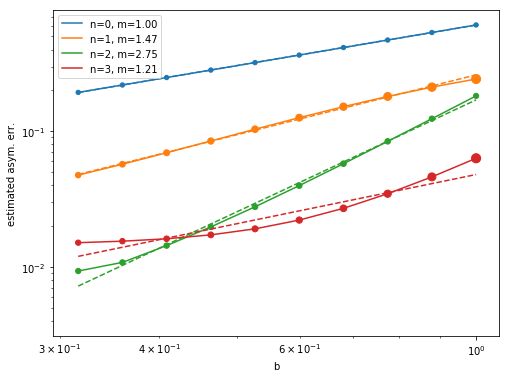

In [427]:
plt.figure(figsize=(8,6))
for i, num_scatters in enumerate(num_scatters_list):
    m_err, b_err = robust_exp_regression(b_list, tot_err_arr[:, i])
    plt.plot(b_list, tot_err_arr[:,i], 'C{}-'.format(i), label='n={}, m={:.2f}'.format(num_scatters, m_err))
    plt.plot(b_list, np.exp(b_err)*np.array(b_list)**m_err, 'C{}--'.format(i))
    plt.scatter(b_list, tot_err_arr[:,i], s=1000*(1-asym_r2_arr[:,i]))
plt.legend()
plt.xlabel('b')
plt.ylabel('estimated asym. err.')
plt.yscale('log')
plt.xscale('log')